**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 5s (18.1 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import math

In [0]:
# # Download an example slide and tumor mask
# # Note: these are hosted on Google Cloud Storage.
# # The remainder are in a Google Drive folder, linked above.

# slide_path = 'tumor_091.tif'
# tumor_mask_path = 'tumor_091_mask.tif'

# slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
# mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# # Download the whole slide image
# if not os.path.exists(slide_path):
#   !curl -O $slide_url

# # Download the tumor mask
# if not os.path.exists(tumor_mask_path):
#   !curl -O $mask_url

In [0]:
# slide = open_slide(slide_path)
# print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
#                                                         slide.level_dimensions[0][0], 
#                                                         slide.level_dimensions[0][1]))

# tumor_mask = open_slide(tumor_mask_path)
# print ("Read tumor mask from %s" % (tumor_mask_path))

# print("Slide includes %d levels", len(slide.level_dimensions))
# for i in range(len(slide.level_dimensions)):
#     print("Level %d, dimensions: %s downsample factor %d" % (i, 
#                                                              slide.level_dimensions[i], 
#                                                              slide.level_downsamples[i]))
#     assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
#     assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# # Verify downsampling works as expected
# width, height = slide.level_dimensions[7]
# assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
# assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

## Downloading new images

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#tumor_110
slide1_id = '1tCvyQIXadK0TSJlrwmkQ38caD1HsjevQ'
slideFile1 = drive.CreateFile({'id': slide1_id})
mask1_id = '1jZKrrj-mat0J_ur0CNhkeoYD1Fu-DtJu'
maskFile1 = drive.CreateFile({'id': mask1_id})

#tumor_101
slide2_id = '1vhm5D7106bsCRcf2aTp8r3Y1GLjAsRt_'
slideFile2 = drive.CreateFile({'id': slide2_id})
mask2_id = '1zx_wc1SHnlz_umsqLB0xV13KcVvnbRD3'
maskFile2 = drive.CreateFile({'id': mask2_id})

#094
slide3_id = '1n2pIh-2-wTO0Er5YKye-84YEFsbpq2UH'
slideFile3 = drive.CreateFile({'id': slide3_id})
mask3_id = '1ngSHKv9aM8irpP69lziNVYaEo5hxkDnP'
maskFile3 = drive.CreateFile({'id': mask3_id})

# #091
# slide4_id = '11RzjCE_ySgk10IPAJEwv4bfgmaBT2dJP'
# slideFile4 = drive.CreateFile({'id': slide4_id})
# mask4_id = '1hopHZjnPwR7IHMozgJDBre5rdvR_zx0Y'
# maskFile4 = drive.CreateFile({'id': mask4_id})

# #084
# slide5_id = '1fnNUMAhZV5zkFP8joNZ3WexaWSywdtgI'
# slideFile5 = drive.CreateFile({'id': slide5_id})
# mask5_id = '1OWJQkLp2aMOtAqNQVXWacNN-S3P00bA3'
# maskFile5 = drive.CreateFile({'id': mask5_id})


In [0]:
# print('Created file %s with mimeType %s' % (slideFile['title'], slideFile['mimeType']))
# print('Created file %s with mimeType %s' % (maskFile['title'], maskFile['mimeType']))

In [0]:
slideFile1.GetContentFile("tumor_110.tif")
maskFile1.GetContentFile("tumor_110_mask.tif")

slideFile2.GetContentFile("tumor_101.tif")
maskFile2.GetContentFile("tumor_101_mask.tif")

slideFile3.GetContentFile("tumor_094.tif")
maskFile3.GetContentFile("tumor_094_mask.tif")

# slideFile4.GetContentFile("tumor_091.tif")
# maskFile4.GetContentFile("tumor_091_mask.tif")

# slideFile5.GetContentFile("tumor_084.tif")
# maskFile5.GetContentFile("tumor_084_mask.tif")

In [0]:
slide1 = open_slide("tumor_110.tif")
tumor_mask1 = open_slide("tumor_110_mask.tif")

slide2 = open_slide("tumor_101.tif")
tumor_mask2 = open_slide("tumor_101_mask.tif")

slide3 = open_slide("tumor_094.tif")
tumor_mask3 = open_slide("tumor_094_mask.tif")

# slide4 = open_slide("tumor_091.tif")
# tumor_mask4 = open_slide("tumor_091_mask.tif")
# slide5 = open_slide("tumor_084.tif")
# tumor_mask5 = open_slide("tumor_084_mask.tif")

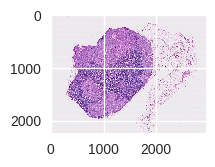

In [11]:
slide_image1 = read_slide(slide1, x=0, y=0, level=5, 
                          width=slide1.level_dimensions[5][0], height=slide1.level_dimensions[5][1])

plt.figure(figsize=(2,2), dpi=100)
plt.imshow(slide_image1)

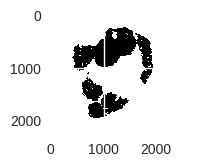

In [12]:
mask_image1 = read_slide(tumor_mask1, x=0, y=0, level=5, 
                        width=slide1.level_dimensions[5][0], height=slide1.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image1 = mask_image1[:,:,0]
#print(mask_image.shape)
plt.figure(figsize=(2,2), dpi=100)
plt.imshow(mask_image1)

In [0]:
slide_image2 = read_slide(slide2, x=0, y=0, level=5, 
                          width=slide1.level_dimensions[5][0], height=slide1.level_dimensions[5][1])
slide_image3 = read_slide(slide3, x=0, y=0, level=5, 
                          width=slide1.level_dimensions[5][0], height=slide1.level_dimensions[5][1])

mask_image2 = read_slide(tumor_mask2, x=0, y=0, level=5, 
                        width=slide1.level_dimensions[5][0], height=slide1.level_dimensions[5][1])
mask_image3 = read_slide(tumor_mask3, x=0, y=0, level=5, 
                        width=slide1.level_dimensions[5][0], height=slide1.level_dimensions[5][1])

## Overlay images

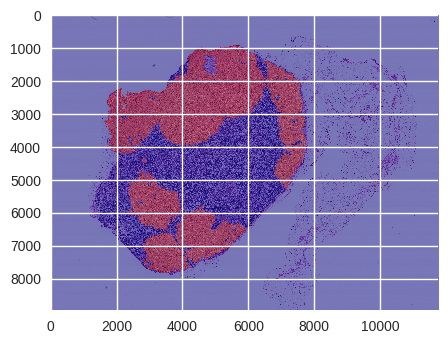

In [14]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image1)
plt.imshow(mask_image1, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
# # Example: extract a region from the L7 downsampled image
# # Notice we're multiplying the x,y coordinates by the downsample factor.
# # This math can be tricky to get right, debug carefully.
# # Here, we're "aiming" for the top right blob in the image above.
# region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
# #region = read_slide(tumor_mask, x=400 * 128, y=450 * 128, level=7, width=50, height=50)[:,:,0]
# plt.imshow(region)

## Generating Training set (discarding non-tissue regions)

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

#tissue_pixels = find_tissue_pixels(slide_image)
#percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
#print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

#tissue_regions = apply_mask(slide_image, tissue_pixels)
#plt.imshow(tissue_regions)

In [24]:
(w_width, w_height) = (40, 40)

print(slide_image1.shape[0]/w_width)
print(slide_image1.shape[1]/w_height)
#slide_image1.shape

56.0
73.6


In [0]:
def sliding_window(image, tumor_image, tissueregion, stepSize=40, w_width=40, w_height=40):
	# slide a window across the imag3
  for x in range(0, image.shape[0], stepSize):
    for y in range(0, image.shape[1], stepSize):
      image_ = image[x:x+w_width, y:y+w_height]
      tissue_ = tissueregion[x:x+w_width, y:y+w_height]
      tissue_ = tissue_.reshape(tissue_.shape[0]*tissue_.shape[1], 3)
      if np.all(tissue_ == np.array([255, 0, 0]), axis = 1).any():
        yield image[x:x+w_width, y:y+w_height], math.ceil(np.mean(tumor_image[x:x+w_width, y:y+w_height]))
        #X_region.append(image[x:x+w_width, y:y+w_height])
        #y_region.

In [0]:
# %%time
# X_patches, y_patches = zip(*sliding_window(slide_image, mask_image, tissue_regions))

# X_patches = np.array([patch for patch in X_patches])
# y_patches = np.array([patch for patch in y_patches])
# #assert X_patches.shape[0] == len(X_indices)
# print(X_patches.shape, y_patches.shape)

(15999, 40, 40, 3) (15999,)
CPU times: user 2.59 s, sys: 0 ns, total: 2.59 s
Wall time: 2.6 s


In [28]:
tissue_pixels1 = find_tissue_pixels(slide_image1)
tissue_regions1 = apply_mask(slide_image1, tissue_pixels1)
X_patches1, y_patches1 = zip(*sliding_window(slide_image1, mask_image1, tissue_regions1))

X_patches1 = np.array([patch for patch in X_patches1])
y_patches1 = np.array([patch for patch in y_patches1])
#assert X_patches.shape[0] == len(X_indices)
print(X_patches1.shape, y_patches1.shape)

ValueError: ignored

In [33]:
len(X_patches1)

2262

In [0]:
from collections import Counter
print(Counter(y_patches))

Counter({0: 15373, 1: 626})


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_patches, y_patches, stratify = y_patches, test_size = 0.2)

print(X_train.shape, y_train.shape)
print()
print(X_test.shape, y_test.shape)

(12799, 40, 40, 3) (12799,)

(3200, 40, 40, 3) (3200,)


In [0]:
def undersampling(X, y):
  majority_index = np.where(y == 0)[0]
  m = (y == 1).sum()
  
  sample_index = np.random.choice(majority_index, size = m, replace = False)
  
  X_sample = np.concatenate((X[sample_index], X[np.where(y == 1)]))
  y_sample = np.concatenate((y[sample_index], y[np.where(y == 1)]))
  
  shuffle_index = np.arange(X_sample.shape[0])
  np.random.shuffle(shuffle_index)
  
  X_sample = X_sample[shuffle_index]
  y_sample = y_sample[shuffle_index]
  
  return X_sample, y_sample

In [0]:
def oversampling(x,y):
  minority_index = np.where(y == 1)[0]
  m = np.sum(y == 0)
  sample_index = np.random.choice(minority_index, m, replace = True)
  x_new = np.concatenate((x[sample_index], x[np.where(y ==0)]))
  y_new = np.concatenate((y[sample_index], y[np.where(y ==0)]))
  
  shuffle_index = np.arange(x_new.shape[0])
  np.random.shuffle(shuffle_index)

  x_new = x_new[shuffle_index]
  y_new = y_new[shuffle_index]
  
  return x_new, y_new

In [0]:
X_sample, y_sample = oversampling(X_train, y_train)

In [0]:
print('0 class: ', (y_sample==0).sum())
print('1 class: ', (y_sample == 1).sum())

0 class:  12298
1 class:  12298


Data Augmentation

In [0]:
#train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#            rotation_range = 40,
#            width_shift_range = 0.2,
#            height_shift_range = 0.2, 
#            horizontal_flip = True,
#            vertical_flip = True,
#            fill_mode = 'nearest')

In [0]:
#test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
# i = 0
# for batch in train_datagen.flow(X_sample, batch_size = 5):
#   plt.figure(i)
#   imgplot = plt.imshow(tf.keras.preprocessing.image.array_to_img(batch[0].reshape(40,40,3)))
#   i += 1
#   if i %10 == 0:
#     break

# plt.show()

In [0]:
# X_sample2, X_val, y_sample2, y_val = train_test_split(X_sample, y_sample, test_size = 0.1)

In [0]:
# train_datagen.fit(X_sample2)

## Baseline Model

In [0]:
import tensorflow as tf
vgg16 = tf.keras.applications.VGG16(weights = 'imagenet',input_shape=(40, 40, 3), include_top=False)
vgg16.trainable=False

In [0]:
# model_gen = tf.keras.Sequential([
#   vgg16,
#   #xception,
#   tf.keras.layers.GlobalAveragePooling2D(),
#   #tf.keras.layers.Flatten(), 
#   #tf.keras.layers.Dense(256, activation='relu'),
#   #tf.keras.layers.Dropout(0.3), # Add dropout to reduce overfitting
#   tf.keras.layers.Dense(128, activation = 'relu'),
#   #tf.keras.layers.Dropout(0.3),
#   tf.keras.layers.Dense(2, activation = 'softmax')])

# model_gen.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9), 
#             loss=tf.keras.losses.sparse_categorical_crossentropy,
#             metrics=['accuracy'])

# model_gen.summary()



In [0]:
model = tf.keras.Sequential([
  vgg16,
  #xception,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Flatten(), 
  #tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(0.3), # Add dropout to reduce overfitting
  tf.keras.layers.Dense(128, activation = 'relu'),
  #tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(2, activation = 'softmax')])

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9), 
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])

model.summary()

#optimizer=tf.train.AdamOptimizer()
#optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 14,780,610
Trainable params: 65,922
Non-trainable params: 14,714,688
_________________________________________________________________


Pre-trained model

In [0]:
#X_sample2.shape

(901, 40, 40, 3)

In [0]:
model.fit(X_sample, y_sample, batch_size = 64, epochs = 10, validation_split = 0.1)

Train on 22136 samples, validate on 2460 samples
Epoch 1/10
22136/22136 [==============================] - 18s 830us/step - loss: 1.5720 - acc: 0.7990 - val_loss: 0.6369 - val_acc: 0.8699
Epoch 2/10
22136/22136 [==============================] - 14s 651us/step - loss: 0.4389 - acc: 0.8708 - val_loss: 0.4347 - val_acc: 0.8870
Epoch 3/10
22136/22136 [==============================] - 14s 653us/step - loss: 0.3565 - acc: 0.8881 - val_loss: 0.3348 - val_acc: 0.8902
Epoch 4/10
22136/22136 [==============================] - 14s 652us/step - loss: 0.2812 - acc: 0.9011 - val_loss: 0.2945 - val_acc: 0.9053
Epoch 5/10
22136/22136 [==============================] - 14s 652us/step - loss: 0.2335 - acc: 0.9162 - val_loss: 0.3353 - val_acc: 0.8496
Epoch 6/10
22136/22136 [==============================] - 14s 652us/step - loss: 0.2322 - acc: 0.9140 - val_loss: 0.2449 - val_acc: 0.9203
Epoch 7/10
22136/22136 [==============================] - 14s 651us/step - loss: 0.1987 - acc: 0.9322 - val_loss: 0.2

In [0]:
# model_history = model_gen.fit_generator(
#     train_datagen.flow(X_sample2, y_sample2, batch_size = 128),
#     steps_per_epoch = 500, epochs = 10,
#     validation_data = test_datagen.flow(X_val, y_val),
#     validation_steps = math.floor(len(X_val)/128))
                          

# #print('Evaluation')

# #evaluation = model.evaluate(ds_test, steps = math.ceil(len(x_test)/32))

# #print('Test set loss: ', evaluation[0])
# #print('Test set accuracy: ', evaluation[1])

# #visualize(model_history)

Epoch 1/10
500/500 [==============================] - 55s 110ms/step - loss: 0.4407 - acc: 0.8204 - val_loss: 0.3554 - val_acc: 0.8306
Epoch 2/10
500/500 [==============================] - 55s 109ms/step - loss: 0.3902 - acc: 0.8311 - val_loss: 0.3548 - val_acc: 0.8487
Epoch 3/10
500/500 [==============================] - 54s 109ms/step - loss: 0.3736 - acc: 0.8334 - val_loss: 0.3968 - val_acc: 0.8405
Epoch 4/10
500/500 [==============================] - 55s 110ms/step - loss: 0.3599 - acc: 0.8337 - val_loss: 0.3691 - val_acc: 0.8438
Epoch 5/10
500/500 [==============================] - 55s 110ms/step - loss: 0.3504 - acc: 0.8391 - val_loss: 0.3504 - val_acc: 0.8520
Epoch 6/10
500/500 [==============================] - 55s 109ms/step - loss: 0.3479 - acc: 0.8394 - val_loss: 0.3271 - val_acc: 0.8520
Epoch 7/10
500/500 [==============================] - 55s 110ms/step - loss: 0.3460 - acc: 0.8403 - val_loss: 0.3054 - val_acc: 0.8635
Epoch 8/10
500/500 [==============================] - 5

In [0]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score

y_predict_label = model.predict(X_sample).argmax(axis = 1)

print('Train Evaluation\n')

print('Recall: ', recall_score(y_sample, y_predict_label))
print('F1: ', f1_score(y_sample, y_predict_label))
print('Precision: ', precision_score(y_sample, y_predict_label))

Train Evaluation

Recall:  0.943649373881932
F1:  0.9462654924983691
Precision:  0.9488961569910057


In [0]:
print('Test 0 class: ', (y_test==0).sum())
print('Test 1 class: ', (y_test == 1).sum())

Test 0 class:  3075
Test 1 class:  125


In [0]:
y_pred = model.predict(X_test).argmax(axis =1)
y_pred.mean()

0.0828125

In [0]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
print('Test Set Evaluation\n')

evaluation = model_gen.evaluate(X_test, y_test)

print('Loss: ', evaluation[0])
print('Accuracy: ', evaluation[1])

print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))

Test Set Evaluation

3200/3200 [==============================] - 2s 772us/step
Loss:  14.983904838562012
Accuracy:  0.0440625
Recall:  0.632
F1:  0.4051282051282051
Precision:  0.2981132075471698


## Fine-tuning

In [0]:
vgg16.trainable = True

for layer in vgg16.layers[:10]:
    layer.trainable = False

In [0]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 40, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 40, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 40, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 20, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 20, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 20, 20, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 10, 10, 128)       0         
__________

In [0]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9), 
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])
model.summary()


#optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 14,780,610
Trainable params: 13,045,122
Non-trainable params: 1,735,488
_________________________________________________________________


In [0]:
#model.layers[-1].get_weights()

In [0]:
# model_gen.fit_generator(
#     train_datagen.flow(X_sample2, y_sample2, batch_size = 128),
#     steps_per_epoch = 150, epochs = 10,
#     validation_data = test_datagen.flow(X_val, y_val),
#     validation_steps = math.floor(len(X_val)/128))

In [0]:
model.fit(X_sample, y_sample, batch_size = 64, epochs = 5, validation_split = 0.1)

Train on 22136 samples, validate on 2460 samples
Epoch 1/5
22136/22136 [==============================] - 30s 1ms/step - loss: 0.2002 - acc: 0.9293 - val_loss: 0.0832 - val_acc: 0.9764
Epoch 2/5
22136/22136 [==============================] - 27s 1ms/step - loss: 0.0585 - acc: 0.9878 - val_loss: 0.0365 - val_acc: 0.9927
Epoch 3/5
22136/22136 [==============================] - 27s 1ms/step - loss: 0.0315 - acc: 0.9958 - val_loss: 0.0289 - val_acc: 0.9931
Epoch 4/5
22136/22136 [==============================] - 27s 1ms/step - loss: 0.0222 - acc: 0.9982 - val_loss: 0.0221 - val_acc: 0.9955
Epoch 5/5
22136/22136 [==============================] - 27s 1ms/step - loss: 0.0193 - acc: 0.9987 - val_loss: 0.0235 - val_acc: 0.9951


In [0]:
y_pred = model.predict(X_test).argmax(axis =1)
y_pred.mean()

0.0353125

In [0]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
print('Test Set Evaluation\n')

evaluation = model.evaluate(X_test, y_test)

print('Loss: ', evaluation[0])
print('Accuracy: ', evaluation[1])

print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))

Test Set Evaluation

3200/3200 [==============================] - 2s 707us/step
Loss:  0.15724264495899887
Accuracy:  0.974375
Recall:  0.624
F1:  0.6554621848739496
Precision:  0.6902654867256637


## just using architecture

In [0]:
import tensorflow as tf
vgg16_ = tf.keras.applications.VGG16(weights = None,input_shape=(40, 40, 3), include_top=False)

In [0]:
model_ = tf.keras.Sequential([
  vgg16_,
  #xception,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Flatten(), 
  #tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(0.3), # Add dropout to reduce overfitting
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(2, activation = 'softmax')])

model_.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9), 
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])

model_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 14,780,610
Trainable params: 14,780,610
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_.fit(X_sample, y_sample, batch_size = 64, epochs = 20, validation_split = 0.1)
#print('Evaluation')

#evaluation = model.evaluate(ds_test, steps = math.ceil(len(x_test)/32))

#print('Test set loss: ', evaluation[0])
#print('Test set accuracy: ', evaluation[1])

#visualize(model_history)

Train on 22136 samples, validate on 2460 samples
Epoch 1/20
22136/22136 [==============================] - 42s 2ms/step - loss: 0.4098 - acc: 0.8055 - val_loss: 0.3135 - val_acc: 0.8585
Epoch 2/20
22136/22136 [==============================] - 41s 2ms/step - loss: 0.3024 - acc: 0.8642 - val_loss: 0.3435 - val_acc: 0.8500
Epoch 3/20
22136/22136 [==============================] - 41s 2ms/step - loss: 0.2694 - acc: 0.8803 - val_loss: 0.2827 - val_acc: 0.8756
Epoch 4/20
22136/22136 [==============================] - 41s 2ms/step - loss: 0.2522 - acc: 0.8907 - val_loss: 0.3016 - val_acc: 0.8711
Epoch 5/20
22136/22136 [==============================] - 41s 2ms/step - loss: 0.2431 - acc: 0.8986 - val_loss: 0.2418 - val_acc: 0.8939
Epoch 6/20
22136/22136 [==============================] - 41s 2ms/step - loss: 0.2174 - acc: 0.9122 - val_loss: 0.1933 - val_acc: 0.9293
Epoch 7/20
22136/22136 [==============================] - 41s 2ms/step - loss: 0.2005 - acc: 0.9240 - val_loss: 0.2065 - val_acc:

In [0]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score

y_predict_label_ = model_.predict(X_sample).argmax(axis = 1)

print('Training Evaluation\n')

print('Recall: ', recall_score(y_sample, y_predict_label_))
print('F1: ', f1_score(y_sample, y_predict_label_))
print('Precision: ', precision_score(y_sample, y_predict_label_))

Training Evaluation

Recall:  1.0
F1:  0.9997154818518067
Precision:  0.9994311255587159


In [0]:
print('Test 0 class: ', (y_test==0).sum())
print('Test 1 class: ', (y_test == 1).sum())

Test 0 class:  3075
Test 1 class:  125


In [0]:
y_pred_ = model_.predict(X_test).argmax(axis =1)
y_pred_.mean()

0.0275

In [0]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
print('Test Set Evaluation\n')

evaluation = model_.evaluate(X_test, y_test)

print('Loss: ', evaluation[0])
print('Accuracy: ', evaluation[1])

print('Recall: ', recall_score(y_test, y_pred_))
print('F1: ', f1_score(y_test, y_pred_))
print('Precision: ', precision_score(y_test, y_pred_))

Test Set Evaluation

3200/3200 [==============================] - 2s 740us/step
Loss:  0.11326544707117137
Accuracy:  0.9796875
Recall:  0.592
F1:  0.6948356807511737
Precision:  0.8409090909090909


** Questions**
- how to download
-- Prof will send an email and maybe upload all
- window size
-- same as model input size
- resize

## Heatmap

In [0]:
import math
width_lim = math.ceil(slide.level_dimensions[3][0]/40)
height_lim = math.ceil(slide.level_dimensions[3][1]/40)

In [0]:
width_lim

192

In [0]:
base = np.zeros((width_lim, height_lim))

In [0]:
pred = model.predict(x_flat)

In [0]:
x_flat.shape

(32256, 40, 40, 3)

In [0]:
pred.shape

(32256, 2)

In [0]:
pred_1=pred[:,1].reshape((height_lim,width_lim))

In [0]:
pred_1.shape

(168, 192)

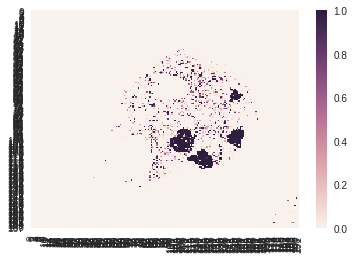

In [0]:
import seaborn
seaborn.heatmap(a)

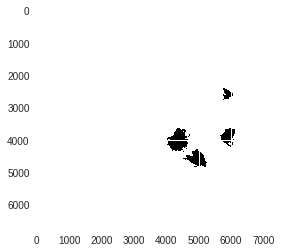

In [0]:
plt.imshow(mask_image)